# CAshflow Optimization System


## 1 Description

CAOS is a prototype simulation-based decision support system for cash-flow planning. It is designed to help users manage financial transactions with multiple vendors and clients and provide insight for further negotiations. Based on user input, the system generates and evaluates a large number of scenarios that aim to represent possible negotiation outcomes. An integral part of the scenario evaluation process is the UPF (Unified Planning Framework) provided by AIPlan4EU. UPF is used to model negotiation scenarios as planning problems and solve them so as to gather information about the action sequence that will lead to the best outcome for the end user. The evaluation results are post-processed and provided as a feedback to the user to aid any upcoming negotiations. Once a negotiation is finalized (or cancelled), the user is able to input the finalized negotiation details back to the system, and progress to the next planning period. 

## 2 Architecture

Overall, the CAOS TSB consists of four interconnected modules : a) the negotiation prediction module, b) the scenario generation module, c) the planning module and d) the plan evaluation module. In the following sections more details about each individual module are provided.


### 2.1 Negotiation Prediction Module

The negotiation prediction module is a standalone python module that aims to simulate the behavior of counterparties during negotiations as accurately as possible. Negotiation activities within CAOS involve three options: a) Choose to defer a payment or not, b) Propose a different interest rate that alters the total amount of the transaction and c) Choose whether or not the transaction will be completed in a single or multiple payments. In addition, a counterparty may be insusceptible to enter negotiations or be very cautious with deferring payments by a long time margin.

Taking all the above into consideration, the goal of this module is to estimate the acceptance probability of the proposed options by utilizing pre-specified parametric probability distribution functions. For this purpose, a personalized configuration has to be provided for every counterparty. These configurations include a set of parameters that can be used to define specific behavioral aspects. In the following sub-sections, we present all the parameters that are included into a counterparty's configuration but also the way they are used within CAOS.


#### 2.1.1 Negotiation Openness

Different counterparties, may adopt different policies with regards to entering a negotiation. In other words, there may be a high variance when it comes to the openness to negotiation of different counterparties. In CAOS, a parameter $0 \leq \delta \leq 1$ is used as a threshold to describe this behavioral aspect. The higher the value of $\delta$, the higher the probability for a counterparty to enter negotiations. This parameter is particularly important during schedule generation as it can be used to estimate whether or not a payment will be altered or not based on the negotiation openness of a counterparty.

#### 2.1.2 Interest Rate Acceptance Behavior

The acceptance probability of interest rates is modelled using the cumulative distribution function of the logistic distribution, i.e., the logistic function.

$$F^I(x,\alpha,\beta) = \frac{1}{1 + e^{-\alpha(x-\beta)}}$$


In the above equation, parameters $\alpha$ and $\beta$ control the shape of the curve, while $x$ represents an interest rate. More specifically, parameter $\alpha$ controls the logistic growth, or the steepness of the curve, while parameter $\beta$ controls the mid-point of the function. This curve acts as a realistic simulator of the behavior of any counterparty as it can be used to model cases where a counterparty's acceptance probability drops either gradually or abruptly, but also the point, i.e., a specific interest rate, that the counterparty's behavior is predisposed negatively.

For example, with regards to inbound payments, it is expected that counterparties may always accept proposals of negative interest rates, i.e., cases where the transaction amount decreases, and neglect proposals of positive interest rates, i.e. cases where the transaction amount increases. In a similar fashion, a reversed behavior is expected regarding outbound payments.

For better modeling and simulation accuracy, two set of parameters are defined per counterparty, so as to allow for a distinct prediction curve for inbound and outbound transactions. In the following, we visualize the acceptance probability for a range of interest rates for a set of clients for both inbound and outbound payments. 

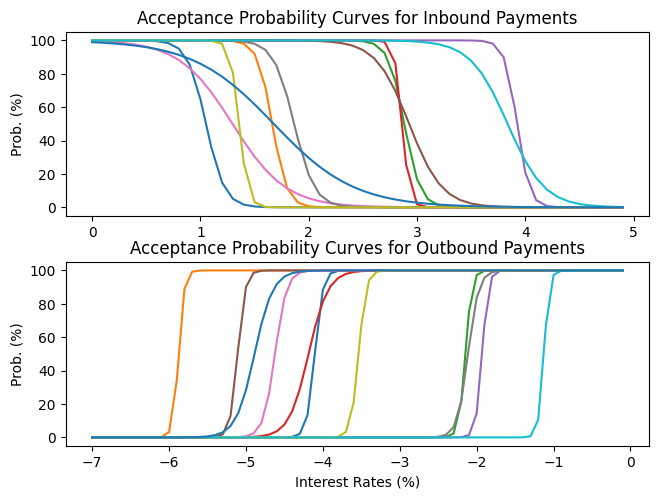

In [1]:
from problem import CAOSProblem
from common import ContractType

from negotiation_prediction import InterestRatePrediction
import matplotlib.pyplot as plt

### Create problem object and load data
p = CAOSProblem()
#p.CreateRandomInstance()
p.ImportState("gen_data.json")

f, ax = plt.subplots(2,1)

#Inbound Probabilities
x = [v * 0.1 for v in range(0, 50)]

for c in p.clients:
    y = [InterestRatePrediction.FindRateProbability(c, ContractType.INBOUND, v) * 100 for v in x]
    ax[0].plot(x, y, label=c.name)

#Outbound Probabilities
x = [v * 0.1 for v in range(-70, 0)]

for c in p.clients:
    y = [InterestRatePrediction.FindRateProbability(c, ContractType.OUTBOUND, abs(v)) * 100 for v in x]
    ax[1].plot(x, y, label=c.name)


ax[0].set_title("Acceptance Probability Curves for Inbound Payments")
ax[1].set_title("Acceptance Probability Curves for Outbound Payments")
ax[1].set_xlabel("Interest Rates (%)")
ax[0].set_ylabel("Prob. (%)")
ax[1].set_ylabel("Prob. (%)")
#ax[0].legend()

f.tight_layout(pad=0.025)
#f.suptitle("Interest Rate Acceptance Probability Curves")

plt.show()

#### 2.1.3 Max Deferral Date

An important characteristic of a counterparty that should be taken into account during negotiations, is its financial flexibility. In other words, how flexible a counterparty is so as to defer inbound or outbound payments back and forth within the planning horizon. Counterparties with tight budget and short-term planning, are very likely to avoid long term negotiations that may hurt their day to day balance, while others may be more flexible and open to negotiate in a wider planning horizon. Within CAOS, a parameter $\epsilon$ is used to describe the length of the maximum time range that a counterparty is willing to defer its payments (inbound or outbound) backwards or forwards in time. The higher the value, the longer the deferral of an inbound or outbound payment may be compared to its original due date.


#### 2.1.4 Deferral Date Acceptance

Regardless of how flexible or not a counterparty is, it is of crucial important to estimate the probability of acceptance of a counterparty with respect to a proposed deferral date for a payment. In this case, the acceptance probability of a deferral date is modelled using a parametric asymptotic function. A parameter is used to control the incline of the function that represents the rate of decline for larger payment deferral periods.

As with the interest rate acceptance probability, with regards to inbound payments, counterparties are very likely to accept deferrals of payments in the future, since this allows them to maintain their positive balance for an extended time period, but also neglect deferrals earlier than expected, since this could possibly have a negative impact on other financial agreements. Similarly, a reversed behavior is expected for outbound payments.

The general form of the asymptotic probability function is:

$$ F^D(x, \gamma) = \frac{\gamma}{x - p_1} + p_2$$

where $p_1, p_2$ are parameters can be calculated as functions of $\epsilon$ and $\gamma \in (0, \frac{\epsilon + 1}{4})$. 


More specifically, for inbound payments $p_1$ and $p_2$ can be calculated as follows:

$$ p_1 = \frac{(1 + \epsilon) \pm \sqrt{(1 + \epsilon)^2 + 4\gamma(\epsilon + 1)}}{2}$$
$$ p_2 = 1 + \frac{\gamma}{p_1}$$

In the case of outbound payments, $p_1$ and $p_2$ can be calculated as follows:

$$ p_1 = \frac{(-1 - \epsilon) \pm \sqrt{(1 + \epsilon)^2 + 4\gamma(\epsilon + 1)}}{2}$$
$$ p_2 = 1 - \frac{\gamma}{p_1}$$


In the following, we visualize the acceptance probability for a range of deferral dates (in periods) for a set of clients for both types of payments.

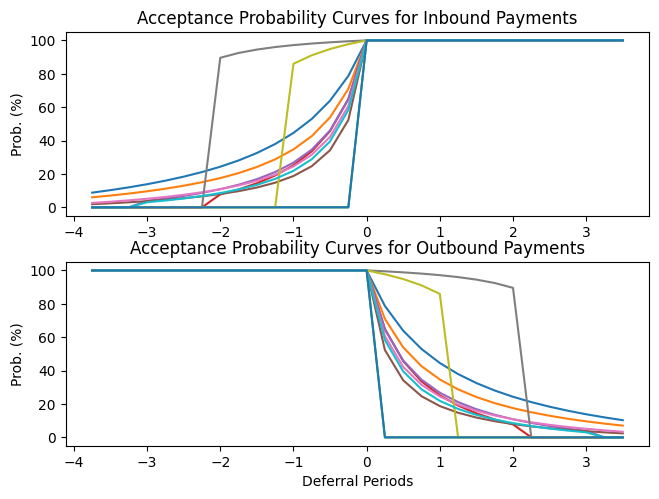

In [2]:
from negotiation_prediction import InterestRatePrediction
import matplotlib.pyplot as plt


f, ax = plt.subplots(2,1)

x = [v * 0.25 for v in range(-15, 15)]

#Inbound
for c in p.clients:
    y = [InterestRatePrediction.FindDeferralProbabilityInbound(c, p) * 100 for p in x]
    ax[0].plot(x, y, label=c.name)

x = [v * 0.25 for v in range(-15, 15)]

#Outbound
for c in p.clients:
    y = [InterestRatePrediction.FindDeferralProbabilityOutbound(c, p) * 100 for p in x]
    ax[1].plot(x, y, label=c.name)

ax[0].set_title("Acceptance Probability Curves for Inbound Payments")
ax[1].set_title("Acceptance Probability Curves for Outbound Payments")
ax[1].set_xlabel("Deferral Periods")
ax[0].set_ylabel("Prob. (%)")
ax[1].set_ylabel("Prob. (%)")
#ax[0].legend()

f.tight_layout(pad=0.025)
plt.show()

### 2.2 Scenario Generation Module


#### 2.2.1 Scenario Generation

The aim of the Scenario Generation module is to generate a wide range of realistic planning scenarios where the stochastic information regarding any current or future negotiations is fixed. Since the goal is to assist the end user for the negotiations of the current time period, the scenario generation module focuses on the earliest payments of the planning horizon. The advantages of this approach are two-fold: a) there is no need to generate any scenarios (and therefore waste useful time and resources) for all payments of the entire planning horizon and b) the system can be more accurate since the real outcome of the most recent negotiations can be input into the system for the next iteration of evaluations.

For a selected contract, the Scenario Generation module will iterate over a selected range of interest rates, deferral periods as well as various installment options and generates several alternative scenarios. Every scenario is generated in three main steps:

* Step 1: A selected interest rate is imposed to the examined contract.
* Step 2: A selected number of installments for the contract.
* Step 2a: In the case of a single installment, select a deferral date for the contract
* Step 3: Find and fix an acceptable rate and deferral date for all the remaining contracts of the planning horizon.

The study of a wide range of interest rates for each examined contract seems an overkill. However, it allows us to make a comprehensive search on scenarios that may not be very probable but may be very profitable for the end user and thus, provide insight for future decisions. In addition, the system utilizes some internal cutoff parameters, so as to omit scenarios with trivially low probabilities.

The process of finding an acceptable rate for the remaining counterparties in Step 3, is a fitness proportionate selection process. More specifically, every rate has specific fitness equal to the acceptance probability of the rate for this particular counterparty and contract. Then an interest rate is selected at random, with the interest rates with higher fitness score having a greater chance of being selected. This process not only favours highly acceptable rates, but also does not completely neglect rates with low fitness scores. Lastly, a very similar process is used for selecting a deferral date for all the remaining contracts of the planning horizon.

The output of the scenario generation process is a *Scenario* object. The method *GeneratePlanningProblem* of the *Scenario* class can be used to generate *PlanningProblem* objects directly. These objects can be used from the Planning module so as to obtain scenario solutions. Subsequently, such objects can be directly by the planning module to obtain the corresponding solution in the form of a *PlanningSolution* object. 


#### 2.2.1 Scenario Probability Calculation

During the generation process, not all payments are in their optimal position in the planning horizon. Thus, the total probability of the scenario cannot be calculated prior to solving it. However, during the generation process, since the system examines one contract at a time, the attributes (i.e, an interest rate, a deferral option and number of installments) are fixed. By taking into account the acceptance probabilities of these attributes, we can estimate the overall acceptance probability $p^D$ of a counterparty to accept this negotiation:

$$p^c=p^I(r)p^D(d)$$

where $r$ is a negotiated interest rate and $d$ is a negotiated deferral option for the examined contract during the generation process. Here $p^I$ and $p^D$ are used to denote the usage of probability functions $F^I$ and $F^D$ to calculate the corresponding acceptance probability of an interest rate or deferral date, respectively. Note that in this prototype installment options that include more than one payment are equivalent, in terms of acceptance probability, with a deferral of the payment for 0 periods.


When a solution of the scenario is available, then for all contracts the information regarding their scheduling within the planning horizon will be known. Therefore, for every contract $i$, there will be a known interest rate $r_i$ as well as a known deferral option $d_i$. Then, assuming a total of $n$ contracts in the scenario, the total probability that all the considered interest rates are accepted can be calculated as follows:

$$p^r=p^I(r_1)p^I(r_2)⋯p^I(r_{n-1})p^I(r_n)$$

Similarly, the total probability that all the considered deferral periods are accepted can be calculated as follows:

$$p^d=p^D(d_1)p^D(d_2)⋯p^D(d_{n-1})p^D(d_n)$$

Lastly, the total probability of the scenario can be calculated as follows:

$$p^s=p^d p^r$$

### 2.3 Planning Module


The Planning Module of the CAOS TSB is responsible for simulating operational scenarios and generate an optimal schedule for all the pending transactions. This module utilizes the Unified Planning (UP) framework to convert a generated scenario into a PDDL model, which is solved using the Enhsp solver (TODO: add reference to the enhsp solver).


### 2.3.1 Problem Description

The planning problem that is solved using the UP framework given a scenario can be defined as follows: There is a set of inbound and outbound payments, $IP$ and $OP$, respectively. All payments have to be completed within a pre-determined planning horizon with duration $T$, while there is also a start balance denoted by $S$. Every payment $i \in IP \cup OP$ is associated with an interest rate $r_i$ that is used to calculate the adjusted payment amount when the payment is completed on an earlier or later period. We also assume that a bank credit line is available at any time. This can be used when the cash inflow is not enough to complete payments towards vendors. To that end, when the net balance for a particular time period is negative, this implies that a specific amount of money should be loaned from the credit line with a particular interest rate. The loan interest rate is also part of the system configuration. The goal is to schedule all inbound and outbound payments so that the net balance at the end of the planning horizon is maximized while in parallel minimizing the total credit line charge.

In the following sections, we provide the required objects required for modeling the planning problem using the UPF framework. The module uses the enhsp-opt solver as it is one of the very few available solvers that support the necessary variable types but also the optimization objectives.



### 2.3.2 User Types


| User Type | Description |
| :- | :- |
| Period | A user type that denotes a period of the planning horizon |
| InContract | A user type that denotes an inbound contract |
| OutContract | A user type that denotes an outbound contract |


### 2.3.3 Fluents

| Fluent Name | Type | Parameter User Type(s) | Description |
| :- | :-: | :-: | :- |
| Start Balance At | Int | Period | A fluent that holds the balance at the start of a particular period |
| Final Balance At | Int | Period | A fluent that holds the balance at the end of a particular period |
| InboundData | Int | Period, InContract | A constant fluent that holds the payment amount of an inbound contract on a specific period |
| OutBoundData | Int | Period, OutContract | A constant fluent that holds the payment amount of an outbound contract on a specific period |
| InContractStatus | Bool | InContract | A fluent that holds the negotiation status of an inbound contract |
| OutContractStatus | Bool | OutContract | A fluent that holds the negotiation status of an outbound contract |
| ConnectedPeriods | Bool | Period, Period | A static fluent that determines the connectivity of period variables. The values of this fluent are initialized so that each period is connected only to its previous and next periods in the planning horizon |
| CurrentPeriod | Bool | Period | A fluent that holds the active period |



### 2.3.4 Actions

| Action Name | Action Parameter(s) | Description | Preconditions | Effects |
| :- | :-: | :- | :- | :- |
| AcceptPayment | Period, InContract | An action that credits a specified amount on the end-user’s balance at the related period when applied. | <ul><li>The related contract should not have been completed, i.e. InContractStatus(*InContract*)==False.</li></ul> | <ul><li>The related contract is marked as completed, i.e. $InContractStatus(InContract) = True$</li><li>The end user balance at the corresponding period is credited accordingly, i.e., $FinalBalanceAt(Period) = FinalBalanceAt(Period) + InboundData(Period, InContract)$</li></ul> |
| PayContract | Period, OutContract | An action that removes a specified amount from the end-user’s balance at the related period when applied. | <ul><li>The related contract should not have been completed, i.e. OutContractStatus(*OutContract*)==False.</li></ul> | <ul><li>The related contract is marked as completed, i.e., $OutContractStatus(OutContract) = True$</li><li>The end user balance at the corresponding period is reduced accordingly, i.e., $FinalBalanceAt(Period) = FinalBalanceAt(Period) - OutboundData(Period, OutContract)$</li></ul> |
| AdvancePeriod | FromPeriod, ToPeriod | An action that makes the transition between the *FromPeriod* to *ToPeriod* period. | <ul><li>*FromPeriod* and *ToPeriod* periods, should be connected, i.e., ConnectedPeriods(*FromPeriod*, *ToPeriod*) == True.</li><li>*FromPeriod* should be the current period, i.e., CurrentPeriod(*FromPeriod*) == True. </li></ul> | <ul><li> The start and final balance of *ToPeriod* is set to $LoanRate \cdot FinalBalanceAt(FromPeriod)$ if and only if the $FinalBalanceAt(FromPeriod) < 0$. </li> <li>The start and final balance of *ToPeriod* is set to $FinalBalanceAt(FromPeriod)$ if and only if the final balance of period FromPeriod is positive. </li></ul> |




### 2.4 Plan Evaluation Module

The Plan Evaluation module of the CAOS TSB is responsible for aggregating and evaluating the solutions generated by the Planning module for all the generated scenarios. The multiple scenarios are generated for the selected range of interest rates, number of installmanets and deferral dates on the payments of the earliest negotiations. At first, the module evaluates the scenario solutions by assigning a score to every scenario. Then, the average score of all evaluated scenarios is assigned to every combination of negotiation parameters (interest rate, number of installments and deferral date) for a specific payment.  Overall, there are three different policies supported by the module that determine the way that scenario scores are calculated:

* Policy A: Weighted Objective Accumulation
* Policy B: Best Objective Accumulation
* Policy C: Best Probability Accumulation

Based on policy A, the score of a scenario is calculated as the objective of the scenario solution weighted by the scenario probability. Using Policy B, the score is equal to the objective of the scenario’s planning solution, while with Policy C, it is equal to the probability of the scenario.

## Basic Usage

The *CAOSProblem* class is the primary class that holds and manages the state of the system. It provides all the necessary functionality to a programmer (a framework) to integrate the system in any other Python application, while also having an -as simple as possible- way to interact with the system. In this section, we showcase a simple example where we manually create a system state and interact with the system.


### Creating / Loading / Saving State

At first, we import the necessary classes from the problem module and then create a new *CAOSProblem* instance.

In [3]:
from problem import CAOSProblem, Client, Contract, Payment, ContractType

#Create Problem
p = CAOSProblem()

We can create new Counterparties, by instantiating the *Client* class.

In [4]:
c1 = Client("Client A", 0.45, 0.14, 0.3, 0.01)
c2 = Client("Client B", 0.25, 0.10, 0.25, 0.02)

We can register the clients to the system.

In [5]:
p.AddCounterParty(c1)
p.AddCounterParty(c2)

True

Now, we can add contracts to the generated counterparties. In particular, we will generate an inbound contract for the first client that includes a single payments for the first period of the planning horizon:

In [6]:
ctr_1 = Contract(ContractType.INBOUND, c1)
pmnt_1 = Payment(ctr_1, 0, 2000)

ctr_1.AddPayment(pmnt_1)

Now, for the 2nd client, we create a new outbound contract with a single payment on the 2nd period of the planning horizon:


In [7]:
ctr_2 = Contract(ContractType.OUTBOUND, c2)
pmnt_4 = Payment(ctr_2, 1, 1500)
ctr_2.AddPayment(pmnt_4)

We can now register the contracts to the system.

In [8]:
p.AddContract(ctr_1)
p.AddContract(ctr_2)

True

The user can overview the current state of the system using the *Report* method

In [9]:
p.Report()

#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 2
### Total Contracts: 2
### Total CounterParties 2
#######################
### Inbound Contracts:
#	 ID: 043 	 Client: Client A 	 Status: UNDER_NEGOTIATION
#		 Period: 000 	 Amount: 2000.00 	 Status: PENDING   
### Outbound Contracts
#	 ID: 044 	 Client: Client B 	 Status: UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 1500.00 	 Status: PENDING   
#######################


This output provides information such as the current balance of the system, the current period and other statistics regarding the total amount of contracts and clients in the system. Also it provides a detailed overview of the registered contracts, the corresponding clients and installments as well as their current status. 

If we wish, we can also export the current state after our modifications to a json file:

In [10]:
p.ExportState("test_state.json")

State json files can be also used to initialize the system.

In [11]:
p = CAOSProblem()
p.ImportState("test_state.json")
p.Report()

#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 2
### Total Contracts: 2
### Total CounterParties 2
#######################
### Inbound Contracts:
#	 ID: 045 	 Client: Client A 	 Status: UNDER_NEGOTIATION
#		 Period: 000 	 Amount: 2000.00 	 Status: PENDING   
### Outbound Contracts
#	 ID: 046 	 Client: Client B 	 Status: UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 1500.00 	 Status: PENDING   
#######################


### Processing and Analyzing State

For the system to make recommendations to the user, the user should at first select a contract and then request an analysis for this particular contract based on the current working state of the system.

### Step 1. Contract Selection


If we want to focus on a specific time range, we can use the `GetContracts` method to retrieve a list of the available contracts in the desired time period range:

In [12]:
ctr_list = p.GetContracts(1,3)
print(len(ctr_list))

1


Otherwise, we can use `GetActiveContracts` to retrieve a list of contracts with scheduled payments on the current period:

In [13]:
ctr_list = p.GetActiveContracts()
print(len(ctr_list))

1


We see that there is a single active contract available for the current period, which is expected. It is the inbound contract of client 1.

Now we want to analyze all the negotiation options for this contract. For this purpose, we can request from the system to generate a list of scenarios based on the input configuration:

In [14]:
ctr = ctr_list[0]
scn_count = p.GenerateScenarios(ctr)
print(scn_count)

210


We see that the system has generated 140 different scenarios based on the possible negotiations for the selected contract. Now we can request the system to analyze these scenarios, i.e., convert them to planning problems and solve them using the UP framework.

In [15]:
p.SolveScenarios()

After solving the scenarios, the planning solutions are cached within the Scenario objects. We can get all the evaluation of the generated solutions by also providing the evaluation policy id that we are interested in.

In [16]:
eval_list = p.GeneratePlanEvaluations(ctr, 1)

Analysis log saved to report.json


Now we can iterate over the evaluation list and decide our way of action. Here we chose to preview the best 5 options according to the policy that we chose.

In [17]:
for i in range(5):
    eval_list[i].Report()

{'Deferral Periods': 1, 'Rate': 1.5, 'Scenarios': 5, 'Weighted Objective': 392.08773780892835, 'Objective': 1429.9999999999998, 'Installments': 1, 'Probability': 0.24523762137131394, 'Decision Probability': 0.3516031059824349}
{'Deferral Periods': 1, 'Rate': 2.5, 'Scenarios': 5, 'Weighted Objective': 349.4200192743532, 'Objective': 1750.0, 'Installments': 1, 'Probability': 0.18929535732207675, 'Decision Probability': 0.2569274376500629}
{'Deferral Periods': 1, 'Rate': 2.0, 'Scenarios': 5, 'Weighted Objective': 322.90439106833844, 'Objective': 1440.0, 'Installments': 1, 'Probability': 0.20283387952256002, 'Decision Probability': 0.30216699461286356}
{'Deferral Periods': 1, 'Rate': 1.0, 'Scenarios': 5, 'Weighted Objective': 319.48588385559407, 'Objective': 1120.0, 'Installments': 1, 'Probability': 0.24848452552232847, 'Decision Probability': 0.40443969774987565}
{'Deferral Periods': 1, 'Rate': 3.0, 'Scenarios': 5, 'Weighted Objective': 167.54848377630464, 'Objective': 1160.0, 'Installmen

If the first option is the one that our client also agreed on we can apply to the current system state, after converting it to an action at first.


In [18]:
action = p.GenerateAction(ctr, eval_list[0])
p.ApplyAction(action)

We can now query the updated state of the system. Notice how the status of the first contract is changed to negotiated. 

In [19]:
p.Report()

#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 2
### Total Contracts: 2
### Total CounterParties 2
#######################
### Inbound Contracts:
#	 ID: 045 	 Client: Client A 	 Status: NEGOTIATED
#		 Period: 001 	 Amount: 2030.00 	 Status: PENDING   
### Outbound Contracts
#	 ID: 046 	 Client: Client B 	 Status: UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 1500.00 	 Status: PENDING   
#######################


# CAOS Command Line Interface (CLI)

For a simpler yet complete usage of the system a command line interface is provided along with the main modules (CAOS CLI).

The interface is also programed in Python and can be very easily started using the following command from a terminal:

![Invocation](img/invokation.png)

Using the `help` command the user can always see the available terminal commands at any time and interact with the system as intended.


![Invocation](img/main_help.png)

Here we can see all the main commands available on the top menu of the interface.

|Command|Description|
|-------|-----------|
|state| Can be used to open the system state management menu|
|help| Outputs all the available commands in the current menu|
|exit| Terminates the application|


At any time the user can use `exit` to terminate the application, while `back` can be used to return the user to the previous menu.


The `state` command can be used to load the state menu and allow the user to manipulate the working state as intended.

Using `help` on the new menu shows all the available commands.

![Invocation](img/state_help.png)

|Command|Description|
|-------|-----------|
|create | Can be used to initialize a new state of the system|
|save   | Can be used to save the current state to a json file|
|load   | Can be used to load a state from a json file|
|config | Can be used to modify the current state's configuration|
|client | Opens the client menu |
|contract | Opens the contract menu |
|analyze   | Performs the state analysis |
|advance | Advances the working state to the next period |
|report   | Provides a summary of the current state of the system|
|action | Opens the action menu |

The `create`, `load` and `save` commands are able to create, load or save the state from and to a json file. The `config` command can be used to alter several parameters of the system such as the number of parallel workers, several probability cutoffs used by the system or the number of evaluations per negotiation option.
The `analyze` command allows the user to analyze the current working state, i.e., the evaluation of all negotiation alternatives for the selected contract.
The `client` command opens a new menu that allows the user to view registered client details but also to register new clients to the system. Similarly, the `contract` menu allows the user to view specific contract details, add new contracts to the system but also select contracts for further analysis.
The `analyze` commands are encapsulations of the procedure already described in the previous section of the notebook. Here, they are more interactive to allow the user to interact with the system on the fly. Similarly, the `action` command opens a new menu that allows the user to select and/or apply a negotiation action.


# Case Study

For a full demonstration of the usage of the system on a realistic use case please see [here](./demo.ipynb).

# Concluding Remarks

CAOS system reveals the great potential that such recommendation systems can have for any user who wants to manage and negotiate their financial transactions in a simple yet efficient way. Thanks to the high level of abstraction with regards to the integration of its sub-modules, the system is highly extensible and can be enhanced in the future with even more adaptive and active learning mechanisms that can allow the system to continuously improve the quality and the reliability of its suggestions. 

The presented demo use-case showcases the importance of evaluating all available negotiation options in a systematic way. Successful negotiations can not only lead to the reduction of corporate debt but also to the increase of the total revenue and thus, significantly improve the financial status of end users. In addition, based on the real negotiation outcomes, users can use this information to inform the system about client behavioral changes and therefore improve the system’s accuracy.

An important role to the total reliability of the system plays the UPF platform. UPF as a unified planning framework, allowed for an easy yet precise modelling of the underlying planning problems defined within CAOS and in addition allowed the experimentation with different planning solvers. The robust approach of the framework allows for swapping between planning engines with minimal implementation effort and thus, makes CAOS able to immediately utilize upgraded versions of existing planning engines, but also to make use of new more efficient planning engines that will be supported by UPF.





